## Задание 5

Необходимо построить модель, позволяющую предсказывать вероятность дефолта клиента. Предлагается построить 2 конкурирующие модели (например, логистическая регрессия и дерево решений) и произвести выбор наилучшей модели на основе показателя качества AUC ROC (площадь под ROC-кривой).

Необходимо описание (не более 3 страниц) логики построения моделей. Также желательно представить графическую интерпретацию результатов.

При построении моделей разрешается использовать любой статистический пакет\платформу, которым вы владеете.


In [1]:
#Подключаем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns

import scipy.stats as stats

import matplotlib.pyplot as plt

import sklearn.metrics as metrics

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, roc_auc_score

from sklearn.preprocessing import StandardScaler

from sklearn import tree

In [2]:
#Загружаем данные, удостоверяемся, что загрузилось верно 
data = pd.read_csv('part5_data.csv', delimiter=";", decimal=',')
data.info()
#data.head(5)
#data.count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
No            10000 non-null object
predictor1    10000 non-null int64
predictor2    10000 non-null int64
predictor3    8087 non-null float64
predictor4    10000 non-null int64
predictor5    10000 non-null float64
target        10000 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 547.0+ KB


### Предобработка данных:

In [3]:
#Удалем столбец No, не содержит информации
data.drop(['No'], axis=1, inplace=True)

In [4]:
# количество строк с фактом дефолта
d1 = data[(data['target'] == 1)]['target'].count()

# количество строк с отсутствием факта дефолта
d0 = data[data['target'] == 0]['target'].count()

print("количество строк с фактом дефолта : ", d1)
print("количество строк с отсутствием факта дефолта : ", d0)

количество строк с фактом дефолта :  1955
количество строк с отсутствием факта дефолта :  8045


In [5]:
# общее количество пропусков
all_nan = data['predictor3'].isna().sum()
print("общее количество пропусков : ", all_nan)

# количество пропусков с фактом дефолта
d1 = data[(data['predictor3'].isna() ) & (data['target'] == 1)]['target'].count()

# количество пропусков с отсутствием факта дефолта
d0 = data[( data['predictor3'].isna() ) & (data['target'] == 0)]['target'].count()


print("количество пропусков с фактом дефолта : ", d1)
print("количество пропусков с отсутствием факта дефолта : ", d0)

общее количество пропусков :  1913
количество пропусков с фактом дефолта :  385
количество пропусков с отсутствием факта дефолта :  1528


In [6]:
# видно, что количество строк с фактом дефолта составляет около 20% от датасета что является не сбалансированным датасетом,
# если обучать модель на таком датасете, то модель будетт переучиваться на класс с существенно большим представлением
# и качество модели будет ниже 

# удалим строки с отсутствием факта дефолта и пропусками признака predictor3 (1528 строк)

d0 = data[ data['target'] == 0 ].dropna()
d1 = data[ data['target'] == 1 ]

data = pd.concat([d0, d1])
data.count()

predictor1    8472
predictor2    8472
predictor3    8087
predictor4    8472
predictor5    8472
target        8472
dtype: int64

In [7]:
# удостоверимся, что оставшиееся количество пропусков равно 
# количеству  пропусков с фактом дефолта(385)
all_nan = data['predictor3'].isna().sum()
print("общее количество пропусков : ", all_nan)

общее количество пропусков :  385


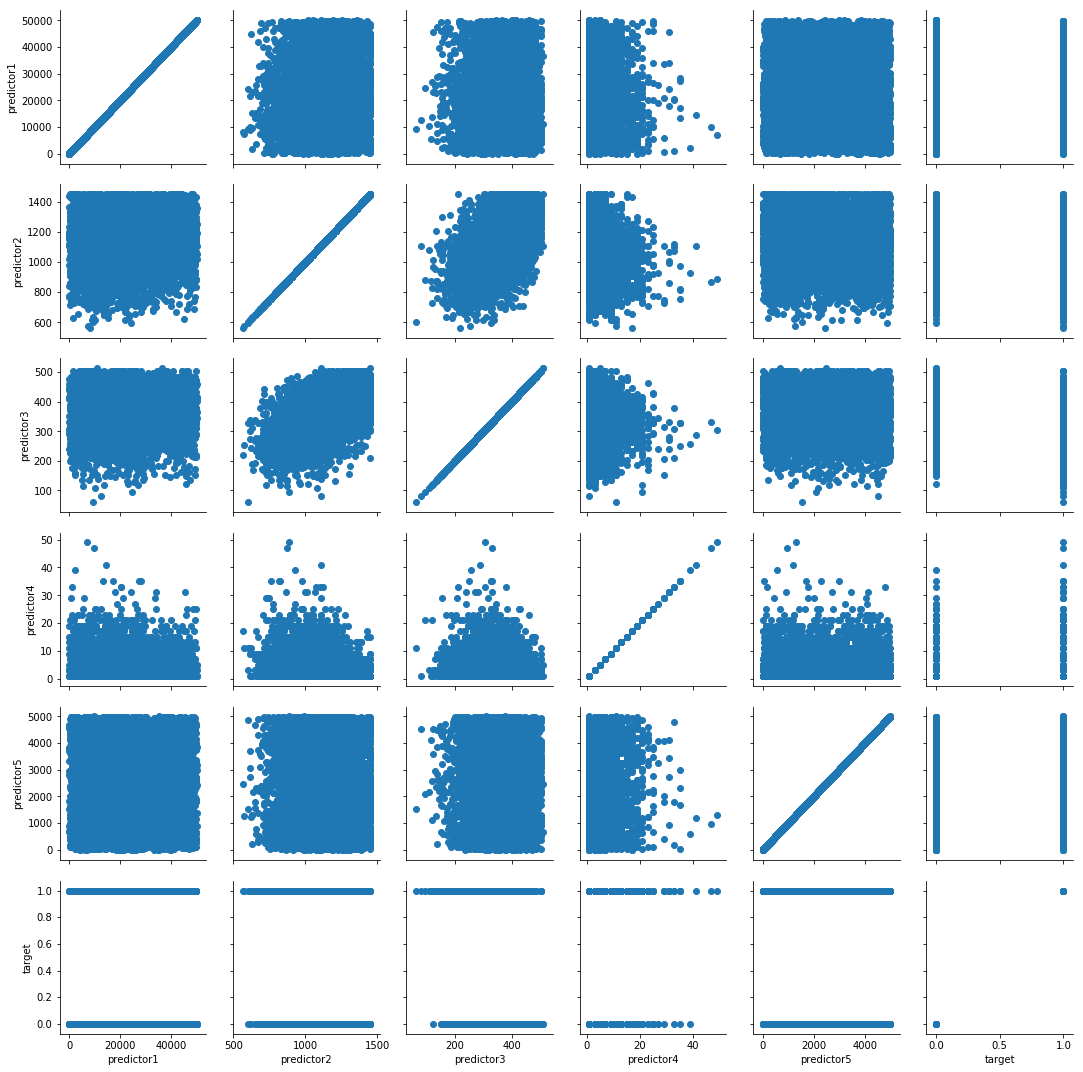

In [8]:
# базовой идеей заполнения пропусков является - подстановкой средненго значения
# другое предположение, что признак predictor3 может кореллировать с другим
# что-бы это проверить построим график зависимости признаков друг от друга

g = sns.PairGrid(data)
g.map(plt.scatter);

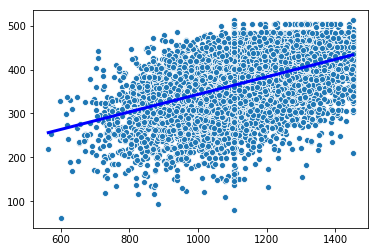

In [9]:
# видим, что сущестует крайне зашумленная корелляция  predictor3 c predictor2. 
# но использование данной зависимости будет более предпочтительным для заполнения пропусков 
# по сравнению с заполнением простыим средним

# создадим простую модель линейной регресси с признаком predictor2 и целевой переменной predictor3

# временная таблица без строк с пропусками
tmp = data[ data['predictor3'].isna() != True ]

x = tmp['predictor2'].to_numpy().reshape(-1, 1)
y = tmp['predictor3'].to_numpy()

reg = LinearRegression().fit(x, y)
y_p = reg.predict(x)
# print(y_p.shape)

# print('intercept_', reg.intercept_)
# print('coef_', reg.coef_)

# проиллюстрируем данную зависимость

x = np.squeeze(x)
y_p = np.squeeze(y_p)
y = np.squeeze(y)

# x = tmp['predictor2'].to_numpy()
# y = tmp['predictor3'].to_numpy()

sns.scatterplot(x=x, y=y)
sns.lineplot(x=x, y=y_p, linewidth=3, color='blue')

In [10]:
#Заполним пропуски признака predictor3  

#Создадим дополнительный столбец со значниниями для predictor3 как предсказания регресии от predictor2 
tmp = data['predictor2'].values.reshape(-1, 1)
data['n3'] = reg.predict(tmp)

#Если NaN берем значение из доп. столбца, иначе оставляем значение
data['predictor3'] = np.where(data['predictor3'].isna(), data['n3'], data['predictor3'])

#Удаляем временный столбец
data.drop('n3', axis=1, inplace=True)

In [11]:
# удостоверимся в отсутствии пропусков
all_nan = data['predictor3'].isna().sum()
print("общее количество пропусков : ", all_nan)

общее количество пропусков :  0


In [12]:
# подготовим датасет с равным распределением целевой переменной target

data = data.sample(frac=1)

d1_data = data[ data['target']==1 ]
d1_count = data[ data['target']==1 ]['target'].count()

d0_data = data[ data['target']==0 ][:int(d1_count)]
normal_distributed_df = pd.concat([d1_data, d0_data])

new_data = normal_distributed_df.sample(frac=1, random_state=42)

In [13]:
# преобразуем в вектора 

y = new_data['target'].to_numpy()
x = new_data.drop('target', axis=1).to_numpy()

# разобьем полученный датасет на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print("размер выборки x_train: %d  размер выборки y_train: %d" % (x_train.shape[0], y_train.shape[0]) )
print("размер выборки x_test: %d размер выборки y_test: %d " % (x_test.shape[0], y_test.shape[0]))

размер выборки x_train: 3128  размер выборки y_train: 3128
размер выборки x_test: 782 размер выборки y_test: 782 


In [14]:
# нормализация и изменение распределения критично для одних алгоритмов и не оказывает влияния на другие.
# например случайный лес, градиентный бустинг, нейронные сети устойчивы к "необычным" распределениям

# нормализацию будем производить по необходимости для конкретных моделей

# Тренировка моделей

## LogisticRegression

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [16]:
# применим модель логистической регрессии из библиотеки scikit-learn с параметрами по умолчанию.
# в качестве метрики будем использовать AUC

reg_model = LogisticRegression(solver='lbfgs').fit(x_train, y_train, )
y_pred = reg_model.predict(x_test)
auc1 = metrics.roc_auc_score(y_test, y_pred) 
print('AUC : {:.4f}'.format(auc1))

AUC : 0.6405


In [17]:
# логистическая регрессия и прочие линейные модели чувствительны к нормализации данных 
# нормализуем датасет
y = new_data['target'].to_numpy()
x = new_data.drop('target', axis=1).to_numpy()
x = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

reg_model.fit(x_train, y_train, )
y_pred = reg_model.predict(x_test)
auc1 = metrics.roc_auc_score(y_test, y_pred) 
print('AUC : {:.8f}'.format(auc1))

#reg_model.get_params()

AUC : 0.66266567


In [18]:
# подбор параметров модели логистической регресси
params={
        "C":np.logspace(.1, 0.5, 1, 3, 7), # Регуляризация
        "penalty":["l1","l2"],  # Тип регуляризации
         }

model = LogisticRegression(solver='liblinear')
reg_model=GridSearchCV(model, params, cv=10)
reg_model.fit(x_train,y_train)

y_pred = reg_model.predict(x_test)
auc1 = metrics.roc_auc_score(y_test, y_pred) 
print('AUC : {:.8f}'.format(auc1))

#reg_model.get_params()

AUC : 0.66266567


In [19]:
# нормализация данных существенно повысила качество модели AUC 0.61 -> 0.65
# тогда как попытка подбора параметров не дала ожидаемого результата. 
# параметры модели по умолчанию уже являются оптимальными(С = 1, penalty = "l2" )

## LightGBM

In [20]:
#Подключаем необходимые библиотеки
import lightgbm as lgbm
from sklearn.model_selection import RandomizedSearchCV

In [21]:
# отмечу, что тесты с нормализацией и без, показали несущественное увеличение качества модели
# поэтому, продолжим с нормализированными данными

In [22]:
model = lgbm.LGBMClassifier(random_state=42, metric='auc', objective='binary')
# metric - метрика оценки результата
# objective - вид классификации

params = {
    'num_leaves': [50, 100, 200, 500, 600, 700, 800], # максимальное количество листьев в дереве
    'feature_fraction': list(np.arange(0.1, 0.5, 1)), # доля параметров(фичей) для следующей итерации
    'min_data_in_leaf': [100, 120, 140, 160, 180, 200], # минимальное количество саймплов для создания листа
    'learning_rate': [0.05], # скорость обучения 
}

# n_iter - количество эпох обучения
# cv - крос валидация, количество раз
# scoring - метрика
grid = RandomizedSearchCV(model, param_distributions=params, n_iter=15, cv=3, scoring='roc_auc')

grid.fit(x_train,y_train)

#выведим лучшие значения параметров
grid.best_params_

{'num_leaves': 700,
 'min_data_in_leaf': 100,
 'learning_rate': 0.05,
 'feature_fraction': 0.1}

In [23]:
y_pred = grid.predict_proba(x_test)[:,1]
auc1 = metrics.roc_auc_score(y_test, y_pred) 
print('AUC : {:.8f}'.format(auc1))

AUC : 0.77916601


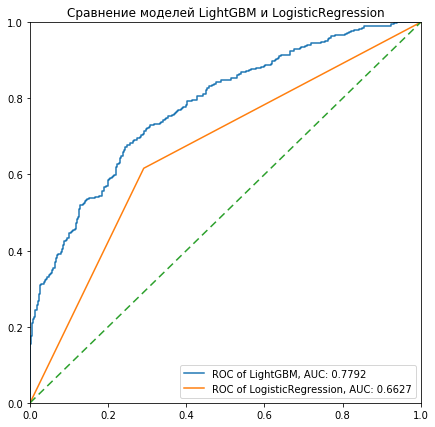

In [24]:
# проиллюстрируем результаты предсказаний моделей 
# отобразим ROC кривые моделей на одном графике 

y_pred1 = grid.predict_proba(x_test)[:,1]
y_pred2 = reg_model.predict(x_test)

fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, y_pred2)

auc1 = np.trapz(tpr1, fpr1)
auc2 = np.trapz(tpr2, fpr2)

fig, axs = plt.subplots( figsize=(7,7))

roc1, = axs.plot(fpr1, tpr1, label="ROC of LightGBM, AUC: {:.4f}".format(auc1) )
roc2, = axs.plot(fpr2, tpr2, label="ROC of LogisticRegression, AUC: {:.4f}".format(auc2) )

plt.title('Сравнение моделей LightGBM и LogisticRegression')
plt.plot([0,1], [0,1], dashes=[5,3])
plt.xlim([0,1]); plt.ylim([0,1])

plt.legend( handles=[roc1, roc2], loc = 'lower right',)
plt.show()

In [25]:
# на графике видно что качество модели на основе LightGBM существенно выше чем качество модели основанной на логистической регрессии  